# NER with LSTM-CRF

It is necessary to install not only tensorflow and keras but also keras-contrib to use this notebook: `pip install git+https://www.github.com/keras-team/keras-contrib.git`

In [1]:
import copy
import os
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import en_core_web_sm
from spacy.tokenizer import Tokenizer
from spacy.lang.en import English

import tensorflow as tf
from keras.models import Model
from keras.layers import Input, Embedding, LSTM, Dense, TimeDistributed, Reshape, Bidirectional, concatenate, Flatten
from keras_contrib.layers import CRF
from keras_contrib.metrics import crf_accuracy
from keras_contrib.losses import crf_loss
from keras.utils import to_categorical

from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing.text import Tokenizer

Using TensorFlow backend.


In [2]:
DATA_PATH = '../data/'
ARTIFACTS_PATH = '../artifacts/'

PARSED_DATA_PATH = DATA_PATH + 'parsed/'
SPLIT_CHAR = ' '
MAX_SEQUENCE_LENGTH = 50

MODEL_NAME = 'ner-lstm-crf'

## Load data

The files `bin_corpus_<>` contain the same texts but as a numbers, where $1$ means that it is a medical term and $0$ that it is just a "common" word.

In [3]:
corpus_train_file = 'corpus_train.txt'
corpus_test_file = 'corpus_test.txt'
bin_corpus_train_file = 'bin_corpus_train.txt'
bin_corpus_test_file = 'bin_corpus_test.txt'

with open(PARSED_DATA_PATH + corpus_train_file, 'r') as fp:
    train_dataset = fp.readlines()

with open(PARSED_DATA_PATH + corpus_test_file, 'r') as fp:
    test_dataset = fp.readlines()

with open(PARSED_DATA_PATH + bin_corpus_train_file, 'r') as fp:
    bin_train_dataset = fp.readlines()
    bin_train_dataset = [s.strip().split(SPLIT_CHAR) if s.strip() != '' else [] for s in bin_train_dataset]
    bin_train_dataset = [np.array(s).astype('int') for s in bin_train_dataset]

with open(PARSED_DATA_PATH + bin_corpus_test_file, 'r') as fp:
    bin_test_dataset = fp.readlines()
    bin_test_dataset = [s.strip().split(SPLIT_CHAR) if s.strip() != '' else [] for s in bin_test_dataset]
    bin_test_dataset = [np.array(s).astype('int') for s in bin_test_dataset]

In [4]:
def get_nlp_engine(basic_tokenizer=False):
    if basic_tokenizer:
        nlp = English()
    else:
        nlp = en_core_web_sm.load()
    return nlp

In [5]:
def tokenize_texts(texts, basic_tokenizer=False):
    texts = texts.copy()
    nlp = get_nlp_engine(basic_tokenizer=basic_tokenizer)
    
    for index, text in enumerate(texts):
        nlp_tokens = nlp(text)
        
        pos = [w.pos_ for w in nlp_tokens]
        lemmas = [w.lemma_.strip() if w.lemma_ != "-PRON-" else w.lower_.strip() for w in nlp_tokens]
        lemmas = [w if any(c.isupper() for c in w) else w for w in lemmas]
        
        # Remove empty tokens
        tokens = [(lemmas[i].strip(), pos[i], nlp_tokens[i]) for i in range(len(nlp_tokens)) if lemmas[i].strip() != '']
        
        texts[index] = tokens
    
    return texts

In [6]:
train_dataset = tokenize_texts(train_dataset)
test_dataset = tokenize_texts(test_dataset)

In [7]:
tok_train_dataset = [[w[0] for w in text] for text in train_dataset]
tok_test_dataset = [[w[0] for w in text] for text in test_dataset]

In [8]:
pos_train_dataset = [[w[1] for w in text] for text in train_dataset]
pos_test_dataset = [[w[1] for w in text] for text in test_dataset]

We need to encode the list of strings into a list of numbers such as every number corresponds unequivocally to a string. Keras has already implemented a function for this purpose: https://keras.io/api/preprocessing/text/

In [9]:
def get_keras_tokenizer(data, num_words=150000):
    tokenizer = Tokenizer(num_words=num_words)
    tokenizer.fit_on_texts(data)
    return tokenizer

In [10]:
def data_to_sequences(data, max_sequence_length, tokenizer=None):
    if tokenizer:
        data = tokenizer.texts_to_sequences(data)

    data = sequence.pad_sequences(data, maxlen=max_sequence_length, padding='post')
    return data

In [11]:
tok_dataset = tok_train_dataset + tok_test_dataset
word_tokenizer = get_keras_tokenizer(tok_dataset)

pos_dataset = pos_train_dataset + pos_test_dataset
pos_tokenizer = get_keras_tokenizer(pos_dataset)

In [12]:
tok_train_dataset = data_to_sequences(tok_train_dataset, MAX_SEQUENCE_LENGTH, word_tokenizer)
tok_test_dataset = data_to_sequences(tok_test_dataset, MAX_SEQUENCE_LENGTH, word_tokenizer)

pos_train_dataset = data_to_sequences(pos_train_dataset, MAX_SEQUENCE_LENGTH, pos_tokenizer)
pos_test_dataset = data_to_sequences(pos_test_dataset, MAX_SEQUENCE_LENGTH, pos_tokenizer)

bin_train_dataset = data_to_sequences(bin_train_dataset, MAX_SEQUENCE_LENGTH)
bin_test_dataset = data_to_sequences(bin_test_dataset, MAX_SEQUENCE_LENGTH)

In [13]:
# For training the network we also need to change the bin_<>_dataset to categorial.
bincat_train_dataset = np.array([to_categorical(i, num_classes=2) for i in bin_train_dataset])
bincat_test_dataset = np.array([to_categorical(i, num_classes=2) for i in bin_test_dataset])

## Create model

The following model is based on the paper of *Zhiheng Huang et al.*: https://arxiv.org/pdf/1508.01991.pdf

In this case I have two different outputs:
- The string sequence.
- The PoS tags sequence.

Remember that both sequences must be numericals.

In [14]:
"""
model_params: dictionary:
- embedding_dim
- lstm_cells
- word_lstm_dropout
- word_lstm_rec_dropout
- pos_lstm_dropout
- pos_lstm_rec_dropout
"""
def create_model(model_params, word_tokenizer, pos_tokenizer, sequence_length):
    word_index = word_tokenizer.word_index
    pos_index = pos_tokenizer.word_index

    word_input = Input(shape=(sequence_length,), name='word_input')
    word_pipe = Embedding(input_dim=len(word_index) + 1,
                          output_dim=model_params['embedding_dim'],
                          input_length=sequence_length,
                          trainable=True)(word_input)
    word_pipe = Bidirectional(
                    LSTM(model_params['lstm_cells'],
                         return_sequences=True,
                         dropout=model_params['word_lstm_dropout'],
                         recurrent_dropout=model_params['word_lstm_rec_dropout']),
                    merge_mode='concat')(word_pipe)
    word_pipe = TimeDistributed(Flatten())(word_pipe)

    pos_input = Input(shape=(sequence_length,), name='pos_input')
    pos_pipe = Embedding(input_dim=len(pos_index) + 1,
                         output_dim=model_params['embedding_dim'],
                         input_length=sequence_length,
                         trainable=True)(pos_input)
    pos_pipe = Bidirectional(
                    LSTM(model_params['lstm_cells'],
                         return_sequences=True,
                         dropout=model_params['pos_lstm_dropout'],
                         recurrent_dropout=model_params['pos_lstm_rec_dropout']),
                    merge_mode='concat')(pos_pipe)
    pos_pipe = TimeDistributed(Flatten())(pos_pipe)
    
    # Concatenate both inputs
    comb_pipe = concatenate([word_pipe, pos_pipe])

    # Main BiLSTM model
    comb_pipe = Bidirectional(
        LSTM(model_params['lstm_cells'], return_sequences=True),
        merge_mode='concat')(comb_pipe)
    comb_pipe = TimeDistributed(Dense(64))(comb_pipe)
    
    output = CRF(2, name='output')(comb_pipe)
    
    model = Model(inputs=[word_input, pos_input], outputs=output)
    model.compile(
        loss=crf_loss,
        optimizer='adam',
        metrics=[crf_accuracy]
    )
    
    return model

## Training

I did not optimize the following parameters. If you want to get the best possible results, use some library to find the optimal parameter values: https://cloud.google.com/ai-platform/training/docs/hyperparameter-tuning-overview#whats_a_hyperparameter

In [15]:
model_params = {
    'embedding_dim': 100,
    'lstm_cells': 50,
    'word_lstm_dropout': 0.3,
    'word_lstm_rec_dropout': 0.3,
    'pos_lstm_dropout': 0.3,
    'pos_lstm_rec_dropout': 0.3
}

model = create_model(model_params, word_tokenizer, pos_tokenizer, MAX_SEQUENCE_LENGTH)
print(model.summary())

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
word_input (InputLayer)         (None, 50)           0                                            
__________________________________________________________________________________________________
pos_input (InputLayer)          (None, 50)           0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 50, 100)      875600      word_input[0][0]                 
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 50, 100)      1800        pos_input[0][0]                  
____________________________________________________________________________________________

In [16]:
EPOCHS = 5

# Add early stop
early_stop = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=2)

history = model.fit(
    {'word_input': tok_train_dataset, 'pos_input': pos_train_dataset},
    bincat_train_dataset,
    epochs=EPOCHS,
    callbacks=[early_stop],
    verbose=1
)

C:\Users\dimas\Anaconda3\lib\site-packages\tensorflow\python\framework\indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/5
7771/7771 [==============================] - 49s 6ms/step - loss: 0.0531 - crf_accuracy: 0.9839
Epoch 2/5
7771/7771 [==============================] - 32s 4ms/step - loss: 0.0227 - crf_accuracy: 0.9933
Epoch 3/5
7771/7771 [==============================] - 32s 4ms/step - loss: 0.0133 - crf_accuracy: 0.9956
Epoch 4/5
7771/7771 [==============================] - 32s 4ms/step - loss: 0.0055 - crf_accuracy: 0.9969
Epoch 5/5
7771/7771 [==============================] - 32s 4ms/step - loss: -0.0010 - crf_accuracy: 0.9977


## Evalutaion

In [17]:
pred_bincat_test_dataset = model.predict({'word_input': tok_test_dataset, 'pos_input': pos_test_dataset})
pred_bin_test_dataset = [np.argmax(s, axis=1) for s in pred_bincat_test_dataset]

In [18]:
def confusion_matrix(real_bin_dataset, pred_bin_dataset):
    if len(real_bin_dataset) != len(pred_bin_dataset):
        raise Exception('Different lengths in lists: %d vs %d' % (len(real_bin_dataset), len(pred_bin_dataset)))
    
    tn = 0
    fp = 0
    fn = 0
    tp = 0
    
    text_i = 0
    len_texts = len(real_bin_dataset)
    
    while text_i < len_texts:
        token_i = 0
        len_text = len(real_bin_dataset[text_i])
        
        while token_i < len_text:
            if real_bin_dataset[text_i][token_i] == 1:
                tp = tp + int(pred_bin_dataset[text_i][token_i] == 1)
                fn = fn + int(pred_bin_dataset[text_i][token_i] == 0)
            else:
                fp = fp + int(pred_bin_dataset[text_i][token_i] == 1)
                tn = tn + int(pred_bin_dataset[text_i][token_i] == 0)
            token_i = token_i + 1

        text_i = text_i + 1
    
    return np.array([[tn, fp], [fn, tp]])

In [19]:
def plot_confusion_matrix(conf_matrix, normalize=True):
    conf_matrix = copy.deepcopy(conf_matrix)
    
    if normalize:
        conf_matrix = np.around(conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis], decimals=2)
    
    label_names = ['Bad', 'Good']
    df_confusion_matrix = pd.DataFrame(conf_matrix,
                                       index=label_names, 
                                       columns=label_names)

    plt.figure(figsize=(5, 5))
    sns.heatmap(df_confusion_matrix, cmap=plt.cm.Blues, annot=True)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

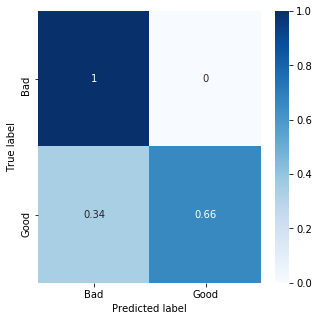

In [20]:
cm = confusion_matrix(bin_test_dataset, pred_bin_test_dataset)
plot_confusion_matrix(cm)

From my point of view, the results are nice: I do not get any false positive, thus I do not identify "false entities" in the text. However, I should keep working on my model to detect all the entities, since there are $34\%$ of them that I am not identifying correctly.

## Make a prediction

Here I do some predictions and transform the categorical output into the entity strings.

In [21]:
def make_bin_pred(model, nlp_text):
    tok_texts = list([[w[0] for w in nlp_text]])
    pos_texts = list([[w[1] for w in nlp_text]])

    tok_texts = data_to_sequences(tok_texts, MAX_SEQUENCE_LENGTH, word_tokenizer)
    pos_texts = data_to_sequences(pos_texts, MAX_SEQUENCE_LENGTH, pos_tokenizer)

    # Make the prediction
    pred_entities = model.predict({'word_input': tok_texts, 'pos_input': pos_texts})
    pred_entities = [np.argmax(s, axis=1) for s in pred_entities]
    
    return pred_entities[0]

In [22]:
def bin_pred_to_str(nlp_text, bin_pred):
    i = 0
    
    text_length = len(nlp_text)
    entities = []

    # Get list of entities separately
    entities_stack = []
    while i < text_length:
        if bin_pred[i]:
            entities_stack.append((i, nlp_text[i][2].text_with_ws))
        i = i + 1

    # Concatenate consecutive entities
    last_pos = None
    for e in entities_stack:
        if last_pos == e[0] - 1:
            last_pos = e[0]
            n_entities = len(entities) - 1
            entities[n_entities] = entities[n_entities] + e[1]
        else:
            last_pos = e[0]
            entities.append(e[1])

    entities = [e.strip() for e in entities]        
    
    return entities

In [23]:
def get_entities(text, model):
    # Put the previous text inside of a list
    texts = list([text])

    # Tokenize it and get PoS tags
    nlp_text = tokenize_texts(texts)[0]

    pred_bin_text = make_bin_pred(model, nlp_text)
    pred_str_entities = bin_pred_to_str(nlp_text, pred_bin_text)
    
    return pred_str_entities

In [24]:
text = 'Germ-line mutations of the BRCA1 gene predispose women to early-onset breast '\
       'and ovarian cancer by compromising the genes presumptive function as a tumor suppressor'

pred_str_entities = get_entities(text, model)

print(pred_str_entities)

['breast and ovarian cancer']


In [25]:
text = 'The patient has been diagnosed with scoliosis.'

pred_str_entities = get_entities(text, model)

print(pred_str_entities)

[]


## Store model

In [26]:
def create_model_dir(model_name):
    model_path = ARTIFACTS_PATH + model_name + '/'
    if not os.path.exists(model_path):
        os.mkdir(model_path)

In [27]:
def save_model(model_name, model):
    create_model_dir(model_name)
    model_path = ARTIFACTS_PATH + model_name + '/'
    model.save_weights(model_path + 'model.h5')

In [28]:
def save_tokenizer(model_name, word_tokenizer, pos_tokenizer):
    create_model_dir(model_name)
    model_path = ARTIFACTS_PATH + model_name + '/'
    
    with open(model_path + 'word_tokenizer.pickle', 'wb') as fp:
        pickle.dump(word_tokenizer, fp, protocol=pickle.HIGHEST_PROTOCOL)
        
    with open(model_path + 'pos_tokenizer.pickle', 'wb') as fp:
        pickle.dump(pos_tokenizer, fp, protocol=pickle.HIGHEST_PROTOCOL)

In [29]:
save_model(MODEL_NAME, model)
save_tokenizer(MODEL_NAME, word_tokenizer, pos_tokenizer)
print('Saved!')

Saved!
